# An algorithm to Learn Polytree Networks with Hidden nodes

## Import Necessary Packages

In [92]:
# Standard library imports
from collections import defaultdict
from itertools import permutations
import copy

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pygraphviz
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
from scipy import stats
from scipy.stats import t
import statsmodels.api as sm

# Enable automatic conversion of R objects to pandas objects
pandas2ri.activate()

In [93]:
'''
# Enable the conversion between Pandas DataFrames and R data.frames
pandas2ri.activate()

# Load and execute the R script
result = ro.r.source("/Users/takeshine/Desktop/simulation/tree_data.R")

returned_list = result[0]

# our synthetc data and edge list information for original polytree
x_data = rpy2py(returned_list[0])  
original_edge_data = rpy2py(returned_list[1])  

'''

'\n# Enable the conversion between Pandas DataFrames and R data.frames\npandas2ri.activate()\n\n# Load and execute the R script\nresult = ro.r.source("/Users/takeshine/Desktop/simulation/tree_data.R")\n\nreturned_list = result[0]\n\n# our synthetc data and edge list information for original polytree\nx_data = rpy2py(returned_list[0])  \noriginal_edge_data = rpy2py(returned_list[1])  \n\n'

In [94]:
# Read our data file 
# file_path = '/Users/takeshine/Desktop/THESIS/code/testing/x_data_testing_1.csv'
file_path = '/Users/takeshine/Desktop/hyper_parameter/paper_data.csv'
df_data = pd.read_csv(file_path)

In [95]:
# Determine the number of columns
n = df_data.shape[1]
# Create a mapping of old column names to new column names
new_columns = {f"V{i+1}": f"y{i+1}" for i in range(n)}

# Rename the columns
df_data = df_data.rename(columns=new_columns)

## Statistical Hypothesis Testing for Correlation Coefficient

This analysis involves determining the significance of a correlation coefficient using a t-test. The key concepts are:

1. **Sample Size (`number_sample`):**
   - Represents the number of observations in the data frame `df_data`, obtained as the first dimension (number of rows) of the data frame.

2. **Significance Level (`alpha`):**
   - The threshold used to determine statistical significance.
   - An `alpha` value of 0.07 implies a 7% risk of concluding a correlation exists when it does not (Type I error).

3. **Degrees of Freedom (`df`):**
   - In correlation tests, degrees of freedom are calculated as `number_sample - 2`.
   - This accounts for the two variables in the correlation coefficient.

4. **Critical t-Value:**
   - Obtained using `t.ppf(1 - alpha/2, df)`.
   - Represents the t-value beyond which the area under the t-distribution curve equals the significance level/2 for a two-tailed test.

5. **Conversion of t-Value to Correlation Coefficient (`threshold_corr`):**
 - The formula used is 

$$ \text{threshold\_corr} = \frac{\text{critical\_t\_value}}{\sqrt{\text{critical\_t\_value}^2 + \text{df}}} $$

- Derived from the relationship between the t-statistic and Pearson correlation coefficient \( r \), where 

$$ t = r \sqrt{\frac{\text{df}}{1 - r^2}} $$
   - `threshold_corr` is the minimum absolute value of the correlation coefficient considered statistically significant for the given sample size and significance level.

In summary, this code calculates the minimum absolute value of the Pearson correlation coefficient necessary for statistical significance, considering the sample size and chosen significance level.


In [96]:
number_sample = df_data.shape[0]
alpha = 0.118   # Significance level
# Degrees of freedom
df = number_sample - 2
# Get critical t-value (two-tailed test)
critical_t_value = t.ppf(1 - alpha/2, df)

# Convert t-value to r (correlation coefficient)
threshold_corr = critical_t_value / (critical_t_value**2 + df)**0.5
threshold_corr

0.004943378808545543

In [97]:
# Calculate the original correlation matrix
original_correlation_matrix = df_data.corr()

# Use the `where` function to replace values, we use 0.05 as our cut
new_correlation_matrix  = df_data.corr().applymap(lambda x: 0 if abs(x) < threshold_corr else 1)

/var/folders/gl/b3dmfy1x5f72lcn0tyw55l_40000gn/T/ipykernel_90536/3244421988.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_correlation_matrix  = df_data.corr().applymap(lambda x: 0 if abs(x) < threshold_corr else 1)


## Task 1: Pairwise-Finite Distance Algorithm (PFDA)

In [98]:
def pairwise_finite_distance_algorithm(new_correlation_matrix):

    new_correlation_matrix = new_correlation_matrix.to_numpy()
    n = new_correlation_matrix.shape[0] # Get the number of nodes

    nodes = [f"y{i + 1}" for i in range(n)]
    sets = {} 

    # Step 1 - 3: for each node, if it's independent from all other nodes, add it to a set
    for i, node in enumerate(nodes):
        if all(new_correlation_matrix[i, np.arange(n) != i]== 0):
            sets[f'S_{i+1},0'] = {node}

    # Step 4 - 9 For each pair of nodes, if they are dependent, add them to a set
    for i, node in enumerate(nodes):
        for j, other in enumerate(nodes):
            if i < j and new_correlation_matrix[i,j] == 1:
                sets[f'S_{i+1},{j+1}'] = {node, other}
                while True:  # Keep adding nodes to the set as long as there exist nodes that are dependent on all nodes in the set
                    old_size = len(sets[f'S_{i+1},{j+1}'])

                    # For each other node, if it's dependent on all nodes in the set, add it to the set
                    for k, another in enumerate(nodes):
                        if k != i and k != j and all(new_correlation_matrix[k,nodes.index(n)] == 1 for n in sets[f'S_{i+1},{j+1}']):
                            sets[f'S_{i+1},{j+1}'].add(another)
                    if len(sets[f'S_{i+1},{j+1}']) == old_size:
                        break
                    
    # Step 10: Create a new dictionary to store the unique sets
    unique_sets = {}
    for key, value in sets.items():
        # Convert the set to a frozenset
        frozenset_value = frozenset(value)
        # Only add the set to the dictionary if it's not already in the dictionary
        if frozenset_value not in unique_sets.values():
            unique_sets[key] = frozenset_value

    # Convert the frozensets back to sets
    unique_sets = {key: set(value) for key, value in unique_sets.items()}

    return unique_sets

In [99]:
unique_sets =  pairwise_finite_distance_algorithm(new_correlation_matrix)

In [100]:
# Rename the output sets of task1 
task1_sets =  {}
# Interate through the unique sets, renaming them and optionally reordering the elements, preparing for task2 
for i, (key, value) in enumerate(unique_sets.items()):
    new_name = f'S_{i + 1}'
    sorted_value = sorted(value, key=lambda x: int(x[1:]))
    task1_sets[new_name] = sorted_value
    

In [101]:
task1_sets

{'S_1': ['y1', 'y10', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17'],
 'S_2': ['y2', 'y10', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17'],
 'S_3': ['y2', 'y16', 'y17', 'y18'],
 'S_4': ['y3', 'y6', 'y12', 'y13'],
 'S_5': ['y3', 'y12', 'y13', 'y17'],
 'S_6': ['y4', 'y5', 'y7'],
 'S_7': ['y4', 'y5', 'y16'],
 'S_8': ['y5', 'y14', 'y15', 'y16', 'y17'],
 'S_9': ['y6', 'y7', 'y12', 'y13'],
 'S_10': ['y6', 'y8'],
 'S_11': ['y6', 'y12', 'y13', 'y16'],
 'S_12': ['y6', 'y16', 'y18'],
 'S_13': ['y7', 'y9'],
 'S_14': ['y8', 'y11', 'y15'],
 'S_15': ['y9', 'y16', 'y17', 'y18'],
 'S_16': ['y11', 'y14', 'y15', 'y16']}

## Task 2: Reconstruction Algorithm for Latent Rooted Trees

### Prepare inputs for Task 2

- Use partial correlations to represent conditonal independence statements
- Use linear regression to calcluate partial correlation:https://en.wikipedia.org/wiki/Partial_correlation
- we use t test to determine the cut out value for partial correlations

In [102]:
# Create a global variable-to-index mapping
all_variables = [f'y{i}' for i in range(1, n+1)] # recall n is number of columns for df_data
var_to_idx = {var: idx for idx, var in enumerate(all_variables)}
global_partial_correlations = np.full((n,n,n),np.nan)

### Mathematical Explanation of Partial Correlation Calculation

This code calculates the partial correlations between pairs of variables while controlling for a third variable in a dataset.

1. **Partial Correlation**: 
   - Measures the correlation between two variables, controlling for one or more additional variables.

2. **Linear Regression for Residuals**: 
   - Linear regression models are fitted for each variable against the control variable.
   - Residuals (observed - predicted values) are then used for further calculation.

3. **Correlation of Residuals**: 
   - The partial correlation is calculated as the correlation between the residuals of two variables.

4. **Special Cases Handling**: 
   - If only one variable is present, partial correlation is 0.
   - With two variables and no control, it's the Pearson correlation.

5. **Storing Results**: 
   - Partial correlations are stored in a 3D array, indexed by the involved variables.

6. **Handling NaNs and Diagonal Values**: 
   - NaNs in the array are set to 0.
   - Diagonal values in the first two dimensions are set to 1 (correlation of a variable with itself).

In [103]:
def calculate_partial_correlations_for_triplets(data,variables):

    '''
    data as dataframe 
    varibles should be columns of those samples we generated for each varible 
    '''

    # Iterate over all combinations of var1 and var2
    for var1, var2 in permutations(variables, 2):
        if len(variables) == 1:
            partial_correlation = 0 
        elif len(variables) == 2: 
            partial_correlation = data[var1].corr(data[var2])
        else:
            # For each combination of var1 and var2, iterate over the remaining variables as control_var
            for control_var in [var for var in variables if var != var1 and var != var2]:
                
                # Fit the linear regression model for var1 controlled by control_var
                model_var1 = sm.OLS(data[var1], sm.add_constant(data[control_var])).fit()
                residuals_var1 = model_var1.resid

                # Fit the linear regression model for var2 controlled by control_var
                model_var2 = sm.OLS(data[var2], sm.add_constant(data[control_var])).fit()
                residuals_var2 = model_var2.resid

                if np.std(residuals_var1) != 0 and np.std(residuals_var2) != 0:
                # Compute the correlation between the residuals
                    partial_correlation = residuals_var1.corr(residuals_var2)
                else:
                    partial_correlation = 0  # Set a default value
                # Store the result in the 3D array

                i, j, k = var_to_idx[var1], var_to_idx[var2], var_to_idx[control_var]
                global_partial_correlations[i, j, k] = partial_correlation

    # let us set nans to 0 first 
    global_partial_correlations[np.isnan(global_partial_correlations)] = 0

    # diagoal on first 2D should all be one
    for i in range(global_partial_correlations.shape[0]):
        for k in range(global_partial_correlations.shape[2]):
            global_partial_correlations[i,i,k] = 1

In [104]:
# Calculate the partial correlations for each set
for set_name, variables in task1_sets.items():
    calculate_partial_correlations_for_triplets(df_data, variables)

### find the cut for partial correlations

In [105]:
check_list = []
for i in range(global_partial_correlations.shape[0]):
    for j in range(global_partial_correlations.shape[1]):
        for k in range(global_partial_correlations.shape[2]):
            if (global_partial_correlations[i,j,k] != 1 and 
            global_partial_correlations[i,j,k] != 0 and 
            abs(global_partial_correlations[i,j,k])) < 0.3:
                check_list.append(abs(global_partial_correlations[i,j,k]))
print(len(check_list))
check_list.sort()

5758


### Statistical Significance of Partial Correlation Coefficients

This section explains the calculation of the statistical significance of partial correlation coefficients.
https://online.stat.psu.edu/stat505/book/export/html/668


1. **Partial Correlation Coefficient (`r`)**: 
   - The coefficient between two variables, controlling for additional variables.

2. **Sample Size (`n`)**: 
   - The total number of observations in the dataset.

3. **Number of Control Variables (`k`)**: 
   - The number of variables controlled for in the partial correlation.

4. **t-Statistic Calculation**: 
   - Calculated as 
     $$ t = r \sqrt{\frac{n - k - 2}{1 - r^2}} $$
   - Quantifies the statistical significance of the partial correlation.

5. **Degrees of Freedom**: 
   - Calculated as `n - k - 2`.

6. **One-Tailed p-Value**: 
   - Determined using the t-distribution's CDF.
   - Indicates the probability of observing a t-statistic as extreme as the one calculated.

7. **Significance Testing in Loop**: 
   - Various partial correlations are tested for significance.
   - If a p-value is below a specified threshold (e.g., 0.05), the corresponding t-statistic and p-value are printed, and the partial correlation is considered significant.


In [106]:
def partial_corr_significance(r, n, k):
    # Compute the t-statistic
    t_stat = r * np.sqrt((n - k - 2) / (1 - r**2))
    
    # Compute the one-tailed p-value (for positive correlation)
    degree_of_freedom = n - k - 2
    p_value = 1 - stats.t.cdf(abs(t_stat), degree_of_freedom)
    
    return t_stat, p_value

In [107]:
sample_size = df_data.shape[0] # Sample size
k = 1    # Number of control variables

p_value_paramater = 0.08
for partial_corr in check_list:
    t_stat, p_value = partial_corr_significance(partial_corr, sample_size, k)
    if p_value < p_value_paramater: 
        print(f"t-statistic: {t_stat:.4f}")
        print("Choose cut near " + str(partial_corr) )
        threshold = partial_corr
        break

t-statistic: 1.4958
Choose cut near 0.004730198646273368


In [108]:
# We need to set entries whose absolute value is smaller our threshold to zero
global_partial_correlations[np.abs(global_partial_correlations) < threshold] = 0 

###  Task 2: determine the collapased quasi-skeleton of each rooted subtree

In [109]:
def step3_find_terminal_node(V_temp, global_partial_correlations, variable_to_index):
    """
    Determine a visible terminal node in V_temp.

    Parameters:
    - V_temp: Current set of nodes.
    - global_partial_correlations: 3D numpy array of partial correlations.
    - variable_to_index: Dictionary mapping node names to indices.

    Returns:
    - terminal_node: The node with the least number of violating pairs.
    """
    violations_count = {}  # This dictionary will store count of violations for each node_k
    
    for node_k in V_temp:
        idx_k = variable_to_index[node_k]
        excluded_nodes = set(V_temp) - {node_k}
        count = 0
        for (node_i, node_j) in permutations(excluded_nodes, 2):
            if node_i != node_k and node_j != node_k:
                idx_i, idx_j = variable_to_index[node_i], variable_to_index[node_j]
                if global_partial_correlations[idx_i, idx_k, idx_j] != 0:
                    count += 1  # Count this as a violation for node_k
        violations_count[node_k] = count
    
    # Return the node with the least violations
    terminal_node = min(violations_count, key=violations_count.get)
    return terminal_node


In [110]:
def step4_find_linked_node(terminal_node, V_temp, global_partial_correlations, var_to_idx):
    linked_node = None

    if terminal_node:
        idx_k = var_to_idx[terminal_node]
        found_node_l = False
        excluded_nodes_1 = set(V_temp) - {terminal_node}
        for node_l in excluded_nodes_1:
            idx_l = var_to_idx[node_l]
            is_linked = True
            for node_j in excluded_nodes_1:
                idx_j = var_to_idx[node_j]
                if idx_j != idx_l and global_partial_correlations[idx_k, idx_l, idx_j] == 0:
                    is_linked = False
                    break
            if is_linked:
                linked_node = node_l
                break

    # Return the updated V_temp and the linked_node
    return linked_node


In [111]:
def compute_set_K(V_temp, terminal_node, global_partial_correlations, var_to_idx):
    K = []
    while True:
        K_updated = False
        for node_i, node_j in permutations(V_temp, 2):
            if node_i != node_j and node_i not in K:
                idx_i, idx_j = var_to_idx[node_i], var_to_idx[node_j]
                idx_k = var_to_idx[terminal_node]
                if global_partial_correlations[idx_j, idx_i, idx_k] != 0 and node_j not in K:
                    K.append(node_j)
                    K_updated = True
                    break
        if not K_updated:
            break
    return K

In [112]:
def latent_tree_structure_prepare(set_of_nodes, global_partial_correlations, var_to_idx):
    edges = []
    latent_nodes = []
    V_temp = list(set_of_nodes)  # Convert to list for indexing.
    candidates = {}
    K = None # Initialize K as none 

    while True:
        # Step 2a: Check if V_temp has only two nodes
        if len(V_temp) == 2:
            edges.append((V_temp[0], V_temp[1]))
            break
        
        # Step 2b: If more than 2 nodes, proceed to find the terminal node
        terminal_node = step3_find_terminal_node(V_temp, global_partial_correlations, var_to_idx)
        # print(terminal_node)
        
        # Step 4: Check for Linked Node
        linked_node = step4_find_linked_node(terminal_node, V_temp, global_partial_correlations, var_to_idx)
        
        if linked_node:  # If a linked node exists
            edges.append((linked_node, terminal_node))
            V_temp.remove(terminal_node)
        else:  # If no linked node exists
            new_latent = "L" + str(len(latent_nodes) + 1)
            latent_nodes.append(new_latent)
            edges.append((new_latent, terminal_node))
            V_temp.remove(terminal_node)
            
            K = compute_set_K(V_temp, terminal_node, global_partial_correlations, var_to_idx)
            if not K:
                return K,candidates, edges, latent_nodes

            else: 
                for node_j in K:
                    edges.append((node_j, new_latent))
                    idx_j = var_to_idx[node_j]
                    idx_k = var_to_idx[terminal_node]
                    candidates[node_j] = [node_j]
                    for node_i in V_temp:
                        if node_i != node_j and node_i != terminal_node and node_j != terminal_node:
                            idx_i = var_to_idx[node_i]
                            if global_partial_correlations[idx_k, idx_j, idx_i] == 0:
                                candidates[node_j].append(node_i)
            break  # Exit the loop after processing when no linked node exists
    return K, candidates, edges, latent_nodes


In [113]:
def generate_final_latent_structures(sets, global_partial_correlations, var_to_idx):
    all_edges = {}
    all_latent_nodes = {}

    for key, value in sets.items():
        # Initial edges and latent nodes
        _, candidates, initial_edges, initial_latent_nodes = latent_tree_structure_prepare(
            value, global_partial_correlations
            , var_to_idx
            )
        
        # Rename the initial latent nodes
        renamed_initial_latent_nodes = [
            "L_" + key.split('_')[-1] + "_" + str(idx) 
            for idx, _ in enumerate(initial_latent_nodes, 1)]
        rename_dict_initial = dict(zip(initial_latent_nodes, renamed_initial_latent_nodes))
        renamed_initial_edges = [
            (rename_dict_initial[edge[0]] if edge[0] in rename_dict_initial else edge[0], 
                                  rename_dict_initial[edge[1]] if edge[1] in rename_dict_initial else edge[1]) 
                                  for edge in initial_edges]
        
        # Temporary storage for edges and latent nodes for each candidate set
        temp_edges = []
        temp_latent_nodes = []

        # If the candidate set is not empty, proceed to iterate over its values
        if candidates:
            for candidate_key, candidate_value in candidates.items():
                # Edges and latent nodes for the current candidate set
                _, _, candidate_edges, candidate_latent_nodes = latent_tree_structure_prepare(candidate_value, global_partial_correlations, var_to_idx)
                
                # Renaming the latent nodes based on the main set's index and the candidate set's index
                renamed_candidate_latent_nodes = [
                    "L_" + key.split('_')[-1] + "_" + candidate_key + "_" + str(idx) 
                    for idx, _ in enumerate(candidate_latent_nodes, 1)
                    ]
                rename_dict_candidate = dict(zip(candidate_latent_nodes, renamed_candidate_latent_nodes))
                renamed_candidate_edges = [
                    (rename_dict_candidate[edge[0]] if edge[0] in rename_dict_candidate else edge[0], 
                                           rename_dict_candidate[edge[1]] if edge[1] in rename_dict_candidate else edge[1]) 
                                           for edge in candidate_edges
                                           ]
                
                temp_edges.extend(renamed_candidate_edges)
                temp_latent_nodes.extend(renamed_candidate_latent_nodes)

        # Combine initial edges and latent nodes with those obtained from the candidate sets
        combined_edges = renamed_initial_edges + temp_edges
        combined_latent_nodes = renamed_initial_latent_nodes + temp_latent_nodes
        
        # Store the combined edges and latent nodes
        all_edges["E_" + key.split('_')[-1]] = combined_edges
        all_latent_nodes["latent_nodes_" + key.split('_')[-1]] = combined_latent_nodes

        """
        Remove duplicate edges from the edges dictionary.
        """
        # Using set to automatically remove duplicates and then converting back to list
        cleaned_edges = {key: list(set(value)) for key, value in all_edges.items()}

    return cleaned_edges, all_latent_nodes

In [114]:
# Run the function
cleaned_final_edges, all_latent_nodes = generate_final_latent_structures(task1_sets, global_partial_correlations, var_to_idx)
# cleaned_final_edges, all_latent_nodes

In [115]:
cleaned_final_edges

{'E_1': [('y16', 'y17'),
  ('y14', 'y1'),
  ('y17', 'y14'),
  ('y17', 'y15'),
  ('y17', 'y13'),
  ('y14', 'y12'),
  ('y14', 'y10')],
 'E_2': [('y14', 'y2'),
  ('y16', 'y17'),
  ('y17', 'y14'),
  ('y17', 'y15'),
  ('y17', 'y13'),
  ('y14', 'y12'),
  ('y14', 'y10')],
 'E_3': [('y17', 'y18'), ('y17', 'y2'), ('y17', 'y16')],
 'E_4': [('y6', 'y3'), ('y12', 'y13'), ('y13', 'y6')],
 'E_5': [('y13', 'y17'), ('y17', 'y12'), ('y13', 'y3')],
 'E_6': [('L_6_1', 'y5'), ('y7', 'L_6_1'), ('y7', 'y4')],
 'E_7': [('y16', 'y5'), ('L_7_1', 'y4'), ('y16', 'L_7_1')],
 'E_8': [('y16', 'y17'), ('y17', 'y14'), ('y17', 'y15'), ('y17', 'y5')],
 'E_9': [('y12', 'y13'), ('y6', 'y7'), ('y13', 'y6')],
 'E_10': [('y6', 'y8')],
 'E_11': [('y12', 'y6'), ('y13', 'y16'), ('y13', 'y12')],
 'E_12': [('y16', 'y18'), ('y18', 'y6')],
 'E_13': [('y7', 'y9')],
 'E_14': [('y11', 'y15'), ('y11', 'y8')],
 'E_15': [('y16', 'y17'), ('y9', 'y18'), ('y17', 'y9')],
 'E_16': [('y14', 'y11'), ('y15', 'y16'), ('y15', 'y14')]}

In [116]:
all_latent_nodes

{'latent_nodes_1': [],
 'latent_nodes_2': [],
 'latent_nodes_3': [],
 'latent_nodes_4': [],
 'latent_nodes_5': [],
 'latent_nodes_6': ['L_6_1'],
 'latent_nodes_7': ['L_7_1'],
 'latent_nodes_8': [],
 'latent_nodes_9': [],
 'latent_nodes_10': [],
 'latent_nodes_11': [],
 'latent_nodes_12': [],
 'latent_nodes_13': [],
 'latent_nodes_14': [],
 'latent_nodes_15': [],
 'latent_nodes_16': []}

- Combine nodes, edges and latent nodes for each subtree
- collapse the latent nodes to hidden cluster and clean the edges
- visulize the result for task 2 

In [117]:
subtrees = {}  
for i in range(1, len(task1_sets) + 1):

    set_key = 'S_' + str(i)
    edge_key = 'E_' + str(i)
    latent_node_key = 'latent_nodes_' + str(i)
        
    subtree = {
        "nodes": task1_sets[set_key],
        "edges": cleaned_final_edges[edge_key],
        "latent_nodes": all_latent_nodes[latent_node_key]
    }
    subtrees['T_' + str(i)] = subtree

In [118]:
subtrees

{'T_1': {'nodes': ['y1', 'y10', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17'],
  'edges': [('y16', 'y17'),
   ('y14', 'y1'),
   ('y17', 'y14'),
   ('y17', 'y15'),
   ('y17', 'y13'),
   ('y14', 'y12'),
   ('y14', 'y10')],
  'latent_nodes': []},
 'T_2': {'nodes': ['y2', 'y10', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17'],
  'edges': [('y14', 'y2'),
   ('y16', 'y17'),
   ('y17', 'y14'),
   ('y17', 'y15'),
   ('y17', 'y13'),
   ('y14', 'y12'),
   ('y14', 'y10')],
  'latent_nodes': []},
 'T_3': {'nodes': ['y2', 'y16', 'y17', 'y18'],
  'edges': [('y17', 'y18'), ('y17', 'y2'), ('y17', 'y16')],
  'latent_nodes': []},
 'T_4': {'nodes': ['y3', 'y6', 'y12', 'y13'],
  'edges': [('y6', 'y3'), ('y12', 'y13'), ('y13', 'y6')],
  'latent_nodes': []},
 'T_5': {'nodes': ['y3', 'y12', 'y13', 'y17'],
  'edges': [('y13', 'y17'), ('y17', 'y12'), ('y13', 'y3')],
  'latent_nodes': []},
 'T_6': {'nodes': ['y4', 'y5', 'y7'],
  'edges': [('L_6_1', 'y5'), ('y7', 'L_6_1'), ('y7', 'y4')],
  'latent_nodes': ['L_6_1']},
 'T_

In [119]:
collapsed_subtrees = {}
latent_cluster_counter = 1  # Counter for the latent cluster name

for key, subtree in subtrees.items():
    # Create a new name for the latent cluster based on the counter if there are latent nodes in the subtree
    latent_cluster_name = f"C_{latent_cluster_counter}" if subtree['latent_nodes'] else ""
    
    # Create a new list of nodes, removing the old latent nodes and adding the new cluster node
    new_nodes = [node for node in subtree['nodes'] if node not in subtree['latent_nodes']]
    if subtree['latent_nodes']:  # Only add the cluster node if there were latent nodes to begin with
        new_nodes.append(latent_cluster_name)
        latent_cluster_counter += 1  # Increment the counter for the next latent cluster
    
    # Update the edges, replacing any old latent nodes with the new cluster node
    new_edges = []
    for edge in subtree['edges']:
        new_edge = tuple([latent_cluster_name if node in subtree['latent_nodes'] else node for node in edge])
        new_edges.append(new_edge)
    
    collapsed_subtrees[key] = {
        'nodes': new_nodes,
        'edges': new_edges,
        'latent_clusters': [latent_cluster_name] if subtree['latent_nodes'] else []
    }

### Plot all subtrees in one big paper with proper distance

In [120]:
def visualize_all_subtrees_with_axis_limits(ax, subtree, title, scale_factor=1.2):
    """
    Visualize the given subtree on a specific axis using networkx and matplotlib.
    Scale the layout to adjust edge lengths and set axis limits for clear separation.
    
    Parameters:
    - ax: Axis on which to plot the subtree.
    - subtree: Dictionary containing nodes, edges, and latent nodes information.
    - title: Title for the visualization.
    - scale_factor: Factor to scale the layout and adjust edge lengths.
    """
    G = nx.Graph()
    
    for node in subtree['nodes']:
        if node in subtree['latent_clusters']:
            G.add_node(node, color='#FFC0CB')  # Pink color for latent nodes
        else:
            G.add_node(node, color='#AEDFF7')  # Light blue color for regular nodes

    G.add_edges_from(subtree['edges'])
    
    # Use kamada_kawai_layout for better spacing between nodes
    layout = nx.kamada_kawai_layout(G)
    
    # Adjust the node positions by scaling the layout to adjust edge lengths
    for node, (x, y) in layout.items():
        layout[node] = (scale_factor * x, scale_factor * y)
    
    colors = [G.nodes[node]['color'] for node in G.nodes()]
    nx.draw(G, pos=layout, with_labels=True, node_color=colors, node_size=500, 
            font_size=10, font_weight='bold', edge_color='#A9A9A9', ax=ax, 
            width=1.3)  # Thicker edges for clarity
    ax.set_title(title, fontsize=12)  # Adjusted font size for title

    # Set the axis' background color
    ax.set_facecolor('#F5F5F5')  # Light gray background
    
    # Set axis limits to create a boundary around each graph
    ax.set_xlim([-2, 2]) # biggger the number, smaller the graph
    ax.set_ylim([-2, 2])

In [121]:
collapsed_subtrees

{'T_1': {'nodes': ['y1', 'y10', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17'],
  'edges': [('y16', 'y17'),
   ('y14', 'y1'),
   ('y17', 'y14'),
   ('y17', 'y15'),
   ('y17', 'y13'),
   ('y14', 'y12'),
   ('y14', 'y10')],
  'latent_clusters': []},
 'T_2': {'nodes': ['y2', 'y10', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17'],
  'edges': [('y14', 'y2'),
   ('y16', 'y17'),
   ('y17', 'y14'),
   ('y17', 'y15'),
   ('y17', 'y13'),
   ('y14', 'y12'),
   ('y14', 'y10')],
  'latent_clusters': []},
 'T_3': {'nodes': ['y2', 'y16', 'y17', 'y18'],
  'edges': [('y17', 'y18'), ('y17', 'y2'), ('y17', 'y16')],
  'latent_clusters': []},
 'T_4': {'nodes': ['y3', 'y6', 'y12', 'y13'],
  'edges': [('y6', 'y3'), ('y12', 'y13'), ('y13', 'y6')],
  'latent_clusters': []},
 'T_5': {'nodes': ['y3', 'y12', 'y13', 'y17'],
  'edges': [('y13', 'y17'), ('y17', 'y12'), ('y13', 'y3')],
  'latent_clusters': []},
 'T_6': {'nodes': ['y4', 'y5', 'y7', 'C_1'],
  'edges': [('C_1', 'y5'), ('y7', 'C_1'), ('y7', 'y4')],
  'latent_cluste

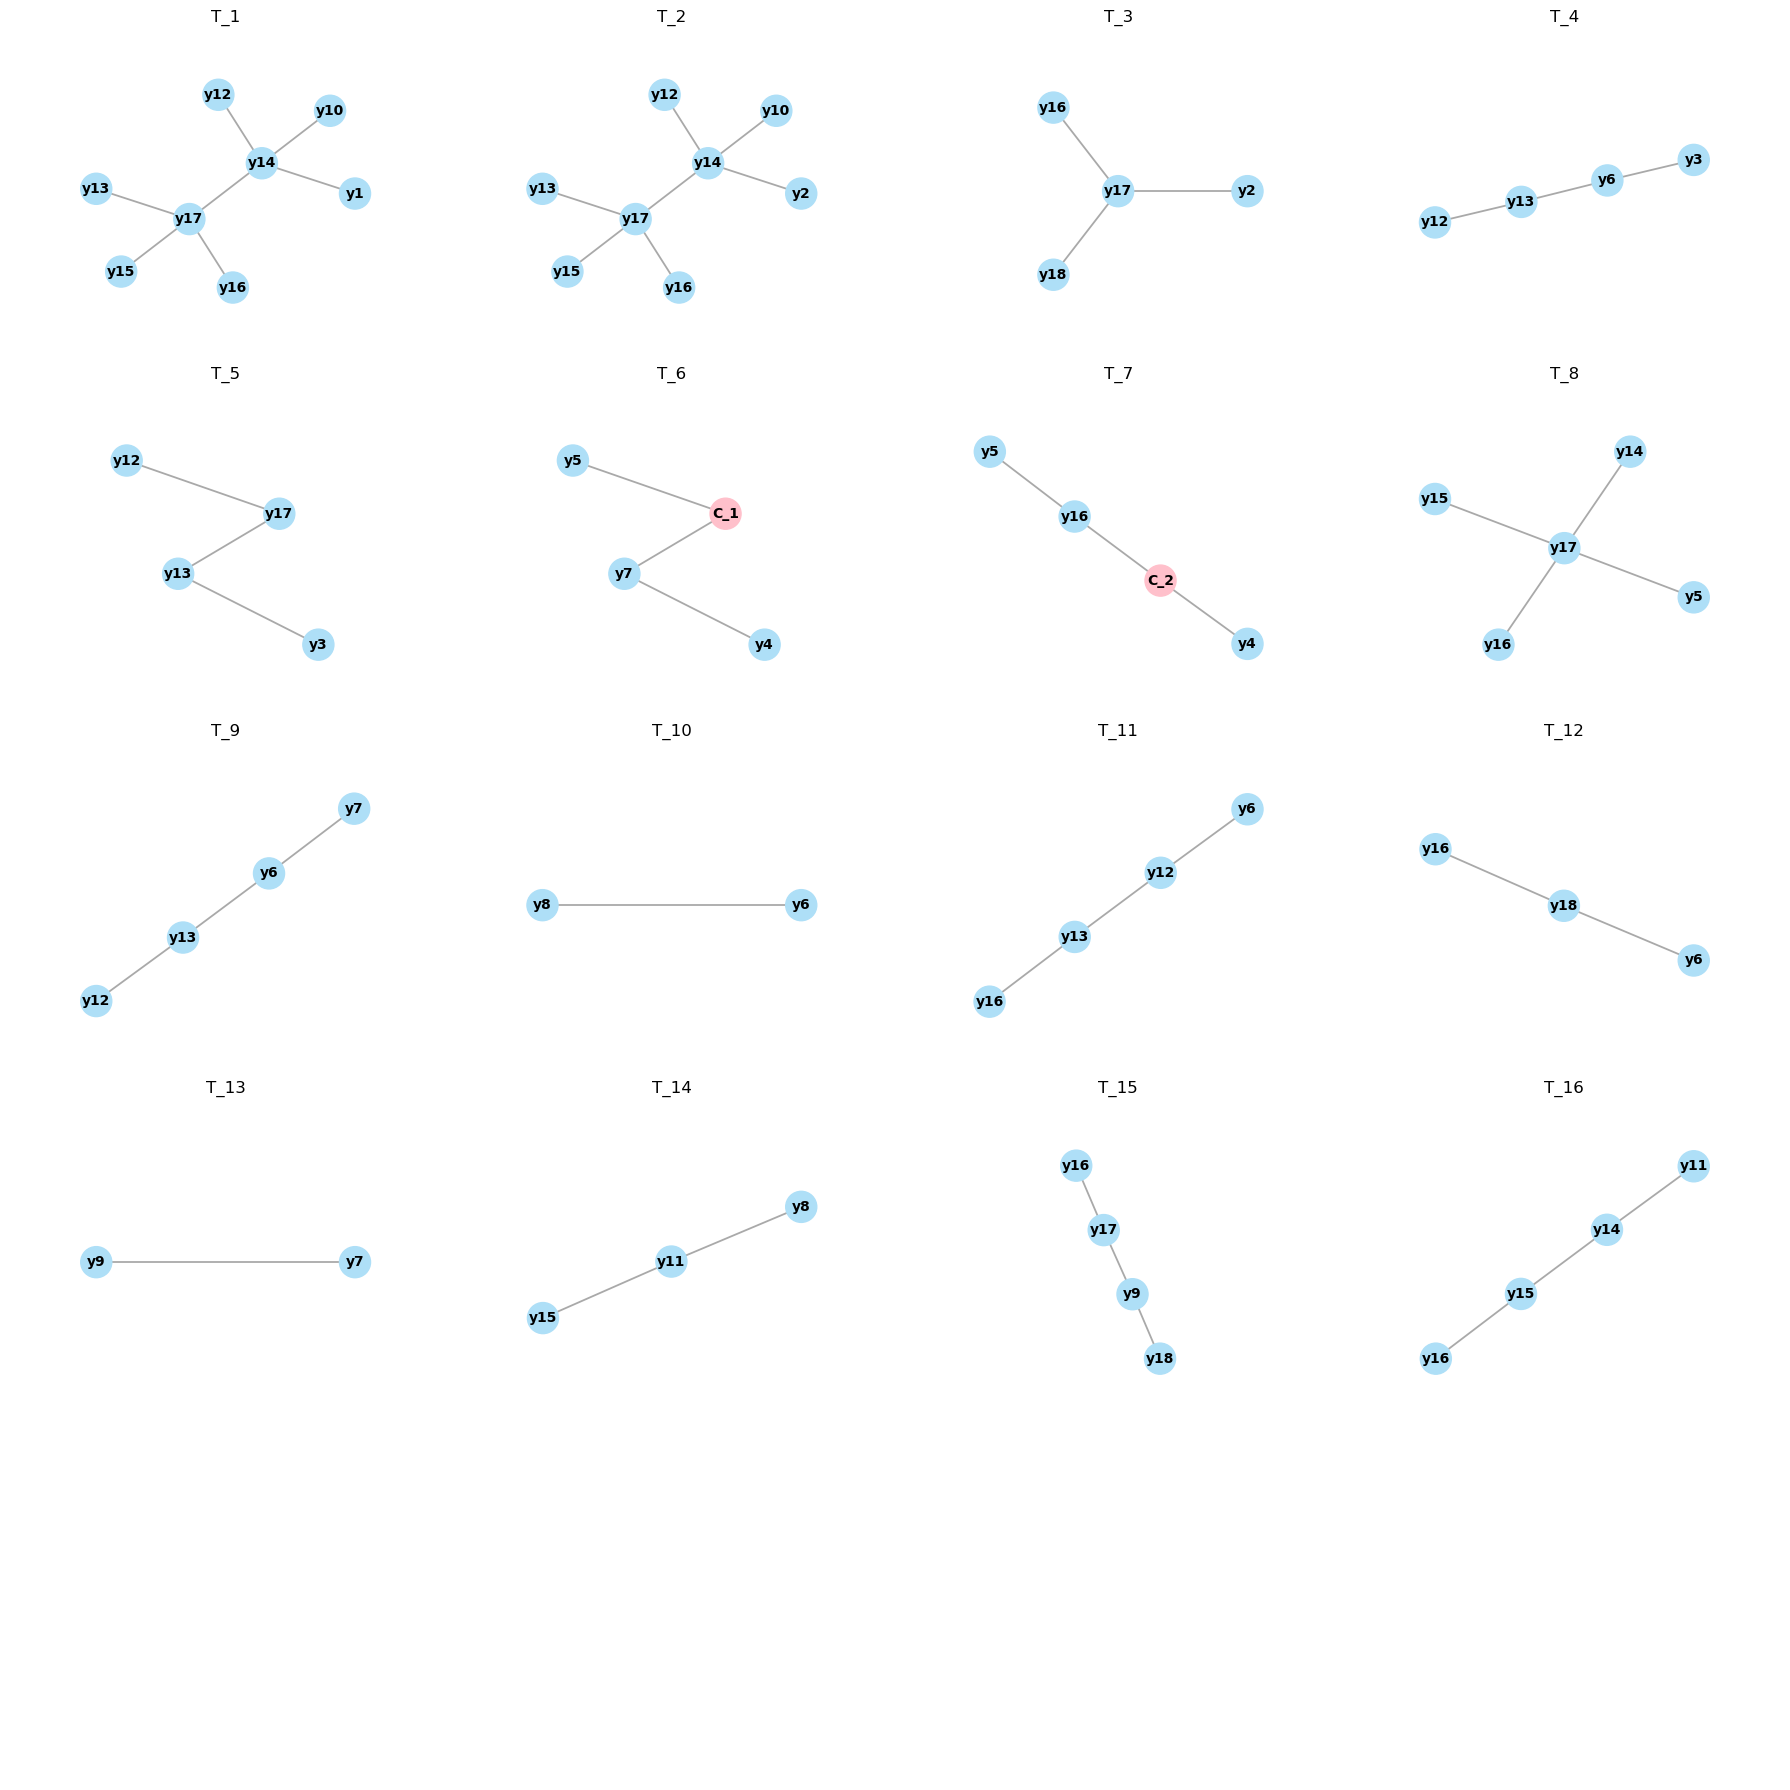

In [122]:
# Initialize a large figure with 5x4 grid
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 18))
fig.subplots_adjust(hspace=0.8, wspace=0.8)  # Increased spacing between subplots

# Visualize each subtree with adjusted edge lengths and axis limits
for ax, (key, subtree) in zip(axes.ravel(), collapsed_subtrees.items()):
    visualize_all_subtrees_with_axis_limits(ax, subtree, key)

# Hide any remaining unused subplots (since we're using a 5x4 grid for 16 subtrees)
for i in range(len(collapsed_subtrees), 5*4):
    axes.ravel()[i].axis('off')

# display
plt.tight_layout()
# plt.savefig("axis_limits_subtrees.png", dpi=300)
plt.show()

- Categorizing subtrees into with/without hidden nodes
- merge substree without hidden nodes first cause no merging crieria needed
- merge subtress with hidden nodes, follow the merging crieria 
- make sure in the end there is no cycles in our final quasi-skeleton of the latent polytree

In [123]:
def visualize_subtree(subtree):
    """
    Visualize the given subtree using the networkx and matplotlib libraries.
    Nodes are colored based on their type (latent or visible), and edges are shown connecting the nodes.
    
    Parameters:
    - subtree: A dictionary containing nodes, edges, and latent_clusters of the subtree.
    """
    
    fig, ax = plt.subplots(figsize=(8, 6))
    G = nx.Graph()
    
    # Ensure all nodes present in edges are in the 'nodes' list
    all_nodes = set(subtree['nodes'])
    for edge in subtree['edges']:
        all_nodes.update(edge)
    
    # Add nodes to the graph
    for node in all_nodes:
        if node in subtree['latent_clusters']:
            G.add_node(node, color='#FFC0CB')  # Pink color for latent nodes
        else:
            G.add_node(node, color='#AEDFF7')  # Light blue color for regular nodes

    # Add edges to the graph
    G.add_edges_from(subtree['edges'])
    
    # Use kamada_kawai_layout for better spacing between nodes
    layout = nx.kamada_kawai_layout(G)
    
    colors = [G.nodes[node]['color'] for node in G.nodes()]
    nx.draw(G, pos=layout, with_labels=True, node_color=colors, node_size=500, 
            font_size=10, font_weight='bold', edge_color='#A9A9A9', ax=ax, 
            width=1.3)  # Thicker edges for clarity
    ax.set_title("Subtree", fontsize=12)  # Adjusted font size for title
    
    plt.show()

In [124]:
def categorizing_subtrees(subtrees):
    subtree_with_hidden_clusters = {}
    subtree_without_hidden_clusters = {}

    for key, subtree in subtrees.items():
        if subtree['latent_clusters']:
            subtree_with_hidden_clusters[key] = subtree
            # Remove latent clusters from the nodes list
            for cluster in subtree['latent_clusters']:
                subtree['nodes'].remove(cluster)
        else:
            subtree_without_hidden_clusters[key] = subtree
            
    return subtree_with_hidden_clusters, subtree_without_hidden_clusters

In [125]:
subtree_with_hidden_clusters, subtree_without_hidden_clusters = categorizing_subtrees(collapsed_subtrees)

In [126]:
def merged_subtrees_without_hidden(subtrees_without_hidden):
    combined_nodes = []
    combined_edges = []

    # Iterate through each subtree and collect nodes and edges
    for _, subtree in subtrees_without_hidden.items():
        combined_nodes.extend(subtree['nodes'])
        combined_edges.extend(subtree['edges'])

    # Convert to set and back to list to ensure uniqueness 
    combined_nodes = list(set(combined_nodes))
    combined_edges = list(set(combined_edges))
    
    # Return the combined subtree
    return{
            "nodes": combined_nodes,
            "edges": combined_edges,
            "latent_clusters": []
    }

In [127]:
def merging_criteria(subtree1, subtree2):
    # Extracting hidden clusters
    cluster1 = subtree1['latent_clusters'][0] if subtree1['latent_clusters'] else None 
    cluster2 = subtree2['latent_clusters'][0] if subtree2['latent_clusters'] else None 

    # If either of the subtrees doesn't have a hidden cluster, merging is not possible  
    if not cluster1 or not cluster2:
        return subtree1, subtree2, False
    
    # Find neighbors of hidden clusters in borh subtrees
    neighbors_cluster1 = {edge[1] for edge in subtree1['edges'] if edge[0] == cluster1} | \
                         {edge[0] for edge in subtree1['edges'] if edge[1] == cluster1}
    neighbors_cluster2 = {edge[1] for edge in subtree2['edges'] if edge[0] == cluster2} | \
                         {edge[0] for edge in subtree2['edges'] if edge[1] == cluster2} 

    
    # Check common neighbors
    common_neighbors = neighbors_cluster1.intersection(neighbors_cluster2)

    if len(common_neighbors) >= 2:
        # merged nodes 
        merged_nodes = list(set(subtree1['nodes'] + subtree2['nodes']))

        # Merge edges, renaming edges connected to cluster2 to clusters 1
        merged_edges = subtree1['edges'] + \
                [(cluster1 if node == cluster2 else node,
                 cluster1 if node2 == cluster2 else node2) 
                 for (node, node2) in subtree2['edges']]


        # create merged subtrees
        merged_subtree = {
            'nodes': merged_nodes,
            'edges': merged_edges,
            'latent_clusters': [cluster1]
        }

        return merged_subtree, {}, True  # Return merged subtree and a flag indicating merging happened
    
    return subtree1, subtree2, False  # If no merging, return original subtrees and a flag indicating no merging


In [128]:
def merge_subtree_with_hidden_clusters_iterative(subtrees):
    """
    This function iteratively merges subtrees based on the merging_criteria. 
    For each subtree, it will attempt to merge with every other subtree until no more merges are possible.
    """
    merged_subtrees = {}
    keys = list(subtrees.keys())
    
    while keys:
        current_key = keys.pop(0)
        current_subtree = subtrees[current_key]
        
        merged = True  # Assume a merge is possible to enter the while loop
        while merged:
            merged = False  # Reset the merged flag for each iteration  
            # Check for a merge with every other subtree
            for other_key in keys:
                merged_subtree, _, did_merge = merging_criteria(current_subtree, subtrees[other_key])
                if did_merge:
                    print("current_clsuters: " + ', ' .join(current_subtree['latent_clusters']))
                    print("being merged cluster" + ', ' .join(subtrees[other_key]['latent_clusters']))
                    current_subtree = merged_subtree  # Update the current subtree to the merged one
                    keys.remove(other_key)  # Remove the merged subtree from keys
                    merged = True  # Mark that a merge has happened
                    break  # Exit the loop and check if the merged subtree can be merged further

        # After no more merges are possible, add the current subtree to the merged subtrees
        merged_subtrees[current_key] = current_subtree

    return merged_subtrees


In [129]:
merged_subtrees_with_hidden_nodes = merge_subtree_with_hidden_clusters_iterative(subtree_with_hidden_clusters)
merged_subtrees_without_hidden_clusters = merged_subtrees_without_hidden(subtree_without_hidden_clusters)

In [130]:
# Merge the subtrees above first, and then we can dectect cycles and start deleting edges
combined_tree = {
    "nodes": merged_subtrees_without_hidden_clusters["nodes"],
    "edges": merged_subtrees_without_hidden_clusters["edges"],
    "latent_clusters": merged_subtrees_without_hidden_clusters["latent_clusters"]
}

# Iterate over each key in merged_subtrees_with_hidden_nodes
for key in merged_subtrees_with_hidden_nodes:
    # Combine nodes
    combined_tree["nodes"].extend(merged_subtrees_with_hidden_nodes[key]["nodes"])
    # Ensure there are no duplicate nodes
    combined_tree["nodes"] = list(set(combined_tree["nodes"]))

    # Combine edges
    combined_tree["edges"].extend(merged_subtrees_with_hidden_nodes[key]["edges"])
    combined_tree["edges"] = list(set(combined_tree["edges"]))

    # Combine latent_clusters
    combined_tree["latent_clusters"].extend(merged_subtrees_with_hidden_nodes[key]["latent_clusters"])
    # Ensure there are no duplicate latent_clusters
    combined_tree["latent_clusters"] = list(set(combined_tree["latent_clusters"]))

In [131]:
combined_tree["nodes"] += combined_tree["latent_clusters"]

In [132]:
# Removing duplicate and reversed edges from combined_tree
unique_edges = set()
cleaned_edges = []

for edge in combined_tree['edges']:
    if edge not in unique_edges and (edge[1], edge[0]) not in unique_edges:
        cleaned_edges.append(edge)
        unique_edges.add(edge)

combined_tree['edges'] = cleaned_edges


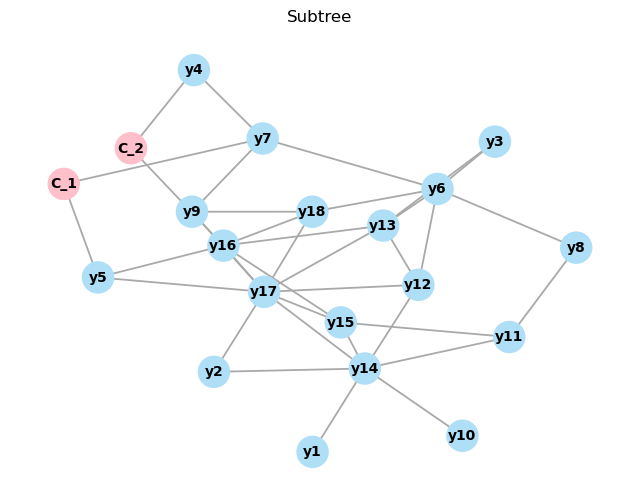

In [133]:
visualize_subtree(combined_tree)

- now delete cycles in a good way
- we clean the edges first, no duplicates
- detect the cycle, only compare the correlation among pairs of visible nodes 
- delete the one has the smallest absolute value of correlation

In [134]:
def detect_cycle(graoh_with_cycles):

    # Extract nodes, edges, and latent_clusters from the combined_tree
    nodes = graoh_with_cycles['nodes']
    edges = graoh_with_cycles['edges']
    latent_clusters = graoh_with_cycles['latent_clusters']

    # Initialize a default dictionary to hold the adjacency list representation of the graph.
    graph = defaultdict(list)
    
    # Get the number of nodes in the graph.
    V = len(nodes)
    
    # Create a dictionary to map node names to indices for easier access.
    node_indices = {node: i for i, node in enumerate(nodes)}
    
    # Initialize a list to keep track of visited nodes during DFS.
    visited = [False] * V
    
    # Construct the graph from the given edges.
    # For an undirected graph, add the edge in both directions.
    for u, v in edges:
        graph[u].append(v)
        graph[v].append(u)
        
    def dfs(v, visited, parent, path):
        # Mark the current node as visited and add it to the current path.
        visited[node_indices[v]] = True
        path.append(v)
        
        for i in graph[v]:
            if not visited[node_indices[i]]:
                if dfs(i, visited, v, path):
                    return True
            elif i != parent:  # A cycle is detected.
                # Capture the cycle by tracing back from the current node to the first occurrence of 'i'.
                cycle_start_idx = path.index(i)
                path.append(i)
                del path[:cycle_start_idx]
                return True
                
        # Backtrack
        path.pop()
        return False
    
    for node in nodes:
        if not visited[node_indices[node]]:
            path = []
            if dfs(node, visited, None, path):
                return True, path
                
    return False, []


In [135]:
def get_index(node_name, latent_clusters):
    # Extract index from node name; modify this based on your actual node naming convention.
    return int(node_name[2:]) if node_name in latent_clusters else -1

In [136]:
def edge_to_remove_from_cycle(cycle, latent_clusters,correlation_matrix):
    cycle_nodes = cycle[1]

     # Filter out edges that involve nodes in the latent_clusters.
    valid_edges = [(cycle_nodes[i], cycle_nodes[i + 1]) for i in range(len(cycle_nodes) - 1) 
                    if cycle_nodes[i] not in latent_clusters and cycle_nodes[i + 1] not in latent_clusters]

    # if there are valid edges
    if valid_edges:
        correlations = [abs(correlation_matrix.loc[edge[0], edge[1]]) for edge in valid_edges]
        # Identify the edge with the smallest absolute correlation.
        min_index = correlations.index(min(correlations))
        return valid_edges[min_index]

    
    else:
        hidden_edges = [(cycle_nodes[i], cycle_nodes[i + 1]) for i in range(len(cycle_nodes) - 1) 
                    if cycle_nodes[i] in latent_clusters or cycle_nodes[i + 1] in latent_clusters]
        
        # Assuming hidden node names are in a format where the index can be extracted and compared.
        max_hidden_node_edge = max(
            hidden_edges, 
            key=lambda edge: max(get_index(edge[0], latent_clusters), 
            get_index(edge[1], latent_clusters))
            )
        return max_hidden_node_edge


In [137]:
def cycle_removal(graph, original_correlation_matrix):
    while True:
        cycle = detect_cycle(graph)
        print(cycle)
        
        if not cycle[0]:# If no cycle detected
            break
        edge_to_delete = edge_to_remove_from_cycle(cycle, graph['latent_clusters'], original_correlation_matrix)
        
        if edge_to_delete in graph['edges']:
            graph['edges'].remove(edge_to_delete)
        elif (edge_to_delete[1], edge_to_delete[0]) in graph['edges']:
            graph['edges'].remove((edge_to_delete[1], edge_to_delete[0]))  
    return graph

In [138]:
updated_tree = cycle_removal(combined_tree, original_correlation_matrix)

(True, ['y13', 'y6', 'y3', 'y13'])
(True, ['y11', 'y15', 'y14', 'y11'])
(True, ['y17', 'y16', 'y13', 'y6', 'y8', 'y11', 'y15', 'y14', 'y2', 'y17'])
(True, ['y17', 'y16', 'y13', 'y6', 'y12', 'y17'])
(True, ['y17', 'y16', 'y15', 'y14', 'y2', 'y17'])
(True, ['y17', 'y16', 'y15', 'y14', 'y17'])
(True, ['y9', 'y17', 'y16', 'C_2', 'y4', 'y7', 'y9'])
(True, ['y16', 'C_2', 'y4', 'y7', 'C_1', 'y5', 'y16'])
(True, ['y17', 'y16', 'C_2', 'y4', 'y7', 'C_1', 'y5', 'y17'])
(True, ['y17', 'y16', 'C_2', 'y4', 'y7', 'y6', 'y13', 'y17'])
(True, ['y17', 'y16', 'C_2', 'y4', 'y7', 'y6', 'y13', 'y12', 'y17'])
(True, ['y17', 'y16', 'C_2', 'y4', 'y7', 'y6', 'y12', 'y17'])
(True, ['y17', 'y16', 'y18', 'y17'])
(True, ['y9', 'y17', 'y16', 'y18', 'y9'])
(True, ['y9', 'y17', 'y12', 'y6', 'y18', 'y9'])
(True, ['y17', 'y12', 'y14', 'y15', 'y17'])
(True, ['y17', 'y15', 'y14', 'y17'])
(False, [])


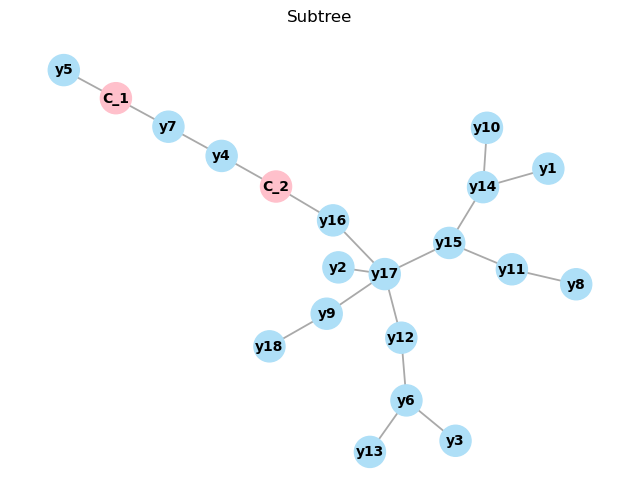

In [139]:
visualize_subtree(updated_tree)

In [140]:
task3_output = updated_tree

- update the output of task 2 so it has updated clusters
- because task4 initially only consider the clusters after the merge of the cluster

In [141]:
def remove_latent_cluster(subtrees_dic_with_latent_clusters):
    """
    Removes latent_clusters and edges associated with them from the subtrees.
    
    Args:
    - collapsed_subtrees (dict): A dictionary representing the subtrees.

    Returns:
    - dict: A new dictionary with latent_clusters removed and corresponding edges filtered out.
    """

    # create a new dictionary to store the modified data
    input_task4_from_task2 = {}

    # iterate through each subtree in the dictionary
    for key, value in subtrees_dic_with_latent_clusters.items():
        # create a deep copy of the current subtree to ensure we don't modify the original data
        new_value = value.copy()
        
        # empty the latent_clusters list
        new_value['latent_clusters'] = []
        
        # filter out edges that contain any latent_cluster
        new_value['edges'] = [
            edge for edge in value['edges'] 
            if not any(node in value['latent_clusters'] for node in edge)
        ]
        
        # add the modified subtree to the new dictionary
        input_task4_from_task2[key] = new_value

    return input_task4_from_task2


In [142]:
def hidden_root_detection (V_tilda, r):

    """
    Function to perform hidden root detection based on V_tilda and a current key.

    :param V_tilda: Dictionary containing V_tilda_i as keys and their corresponding sets.
    :param current_key: Current subtree iteration, e.g., 'T_1', 'T_2', etc.
    
    :return: Returns two dictionaries, left_relative_complement and right_relative_complement.
    """
    # Initialize the result dictionaries 
    left_relative_complement  = {}
    right_relative_complement  = {}

    # Calculate the relative complements 
    V_tilda_r = V_tilda[f'V_tilda_{r}']
    for key, value in V_tilda.items():
        i = int(key.split('_')[2])
        if i != r:
            left_difference = V_tilda_r - value
            right_difference = value - V_tilda_r
        
            left_length = 0 if not left_difference else len(left_difference)
            right_length = 0 if not right_difference else len(right_difference)
        
            left_relative_complement[f'relative_complement_{r}_{i}'] = left_length
            right_relative_complement[f'relative_complement_{i}_{r}'] = right_length

    # check conditions
    all_conditions_met = True
    
    for key, value in left_relative_complement.items():
        # print(key)
        i = int(key.split('_')[3])
        # print(i)

        if i != r:
            left_key =  f'relative_complement_{r}_{i}'
            right_key = f'relative_complement_{i}_{r}'

            left_value = left_relative_complement[left_key]
            # print(left_value)
            right_value = right_relative_complement[right_key]
            # print(right_value)
        
            # check 
            if (left_value <= 1 and right_value >1):
                # print(f"Condition not met for: {key}, left value: {value}, right value: {right_value}")  # Print the issue
                return False
            
    if all_conditions_met:
            return True, r, left_relative_complement, right_relative_complement

In [143]:
def lemma_18(r, left_relative_complement, right_relative_complement, V_tilda, subtree):
    
    big_I = {r}
    big_I_copy = {r}

    for key in left_relative_complement:
        i = int(key.split('_')[3])

        if i!= r:
            left_key =  f'relative_complement_{r}_{i}'
            right_key = f'relative_complement_{i}_{r}'

            left_value = left_relative_complement[left_key]
            # print(left_value)
            right_value = right_relative_complement[right_key]
            # print(right_value)

            if left_value == 1 and right_value == 1:
                big_I.add(i)

    for key in left_relative_complement:
        i = int(key.split('_')[3])

        if i!= r:
            left_key =  f'relative_complement_{r}_{i}'
            right_key = f'relative_complement_{i}_{r}'

            left_value = left_relative_complement[left_key]
            # print(left_value)
            right_value = right_relative_complement[right_key]
            # print(right_value)

            if left_value ==1  and right_value in (0,1):
                big_I_copy.add(i)
            

    # Compute big_W and big_Wbar
    big_W = set().union(*[V_tilda[f'V_tilda_{i}'] for i in big_I])
    big_Wbar = set().union(*[V_tilda[i] for i in V_tilda.keys() if int(i.split('_')[2]) not in big_I])
    intersection_W = big_W & big_Wbar

    # Calculating nodes_linked_to_hidden
    nodes_linked_to_hidden = big_W - big_Wbar

    # Need a second choice of nodes_linked_to_hidden
    big_W_copy = set().union(*[V_tilda[f'V_tilda_{i}'] for i in big_I_copy])
    big_Wbar_copy = set().union(*[V_tilda[i] for i in V_tilda.keys() if int(i.split('_')[2]) not in big_I_copy])
    intersection_W_copy = big_W_copy & big_Wbar_copy


    if not nodes_linked_to_hidden: 
        print("loose the condition")
        differerence = big_W_copy - big_Wbar_copy
        if differerence:
            nodes_linked_to_hidden = {list(differerence)[0]}
            print(nodes_linked_to_hidden)
            return nodes_linked_to_hidden, intersection_W_copy,big_I_copy
        else:
            print("loose the condition again")
            return False
        
    return nodes_linked_to_hidden, intersection_W, big_I

In [144]:
def task_4b(intersection_W, big_I, subtrees, inter_count):
    # print('intersection_W:')
    # print(intersection_W)
    # reorder and deduplicate intersection_W
    intersection_W = sorted(set(intersection_W), key=lambda x: int(x[1:]))

    # initialze n_k
    n_k = len(intersection_W)

    # create n_k number of hidden clusters and add edges 
    for i in big_I:
        for k in range(n_k):
            new_cluster =  f"C_{inter_count}_{i}_{k+1}"
            new_edge =  (new_cluster, intersection_W[k])
            subtree_key = f"T_{i}"
            subtrees[subtree_key]['latent_clusters'].append(new_cluster)
            subtrees[subtree_key]['edges'].append(new_edge)
    return subtrees

In [145]:
def new_hidden_cluster_merging_criteria(cluster1, cluster2, V_tilda_to_compare,subtree):
    # Determine the visible neighbors of each cluster within the subtree
    visible_neighbors_cluster1 = [
        target for node, target in subtree['edges'] 
        if node == cluster1 and target in subtree['nodes']
        ]
    visible_neighbors_cluster2 = [
        target for node, target in subtree['edges'] 
        if node == cluster2 and target in subtree['nodes']
        ]

    # compute the union of the visible neighbors
    visible_neighbors = set (visible_neighbors_cluster1 + visible_neighbors_cluster2)

    # check the overlap with the nodes iin V_tilda_to_compare 
    distinct_nodes_count = sum(1 for V_tilda_nodes in V_tilda_to_compare.values()if len(V_tilda_nodes.intersection(visible_neighbors)) > 0)

    # return True if there are at least 2 distinct nodes, otherwise return False 
    return distinct_nodes_count >= 2

In [146]:
def task_4c(subtree_from_4b, big_I, V_tilda):
    V_tilda_to_compare = {k: v for k, v in V_tilda.items() if int(k.split('_')[-1]) not in big_I}
    
    # Update subtrees based on big_I
    for i in big_I:
        subtree_key = f"T_{i}"
        subtree = subtree_from_4b[subtree_key] 
        latent_clusters = subtree['latent_clusters']

        while latent_clusters:
            any_merge_happened =  False # This flag checks if any merge happended in the entire iteration
            current_cluster = latent_clusters[0]
            merged = True # assume a merger is possible to enter the while loop 

            while merged:
                merged = False # reset the mergerd flag for each iteration
                for other_cluster in [oc for oc in latent_clusters if oc != current_cluster]:
                    if new_hidden_cluster_merging_criteria(current_cluster, other_cluster, V_tilda_to_compare, subtree):
                        latent_clusters.remove(other_cluster) # remove the merged cluster from latent_clusters
                        # modify the edges by using the smaller index's latent cluster 
                        subtree['edges'] = [
                            (current_cluster if node == other_cluster else node, target) 
                            for node, target in subtree['edges']
                            ]
                        merged = True # mark that a merge has happened 
                        any_merge_happened = True
                        break # exit the loop and check if the merged cluster can be merged clusters 
            if not any_merge_happened:
                break
                        
            # after no more merges are possible, add the current cluster to the merged clusters    
        subtree['latent_clusters'] =  latent_clusters
        subtree_from_4b[subtree_key] = subtree # Store the updated subtree in the resulting dictionary

    return subtree_from_4b  

In [147]:
def HMCA(current_tree_key, subtrees, neighbors_of_current_clusters, current_hidden_cluster,inter_count):
    current_key = current_tree_key
    r = int(current_key.split('_')[1])

    # Initialize V_i for each subtree T_i
    V = {key: set(subtree['nodes']) for key, subtree in subtrees.items()}

    # Compute V~i for each subtree T_i
    V_tilda = {f'V_tilda_{key.split("_")[1]}': nodes.intersection(neighbors_of_current_clusters) 
           for key, nodes in V.items()}  

    independence_relation_key = f'independence_{r}'
    independence_relation = set()

    if not V_tilda.get(f'V_tilda_{r}'):   # Check if V_tilda_r is empty
        return subtrees, {independence_relation_key: independence_relation}
    
    if all (not v for v in V_tilda.values()):  # Step 2, Check if all V~i are empty 
        return subtrees, {independence_relation_key: independence_relation}
    
    # only need those that has intersection not empty
    V_tilda = {key: value for key, value in V_tilda.items() if value}

    # Call hidden_root  
    result = hidden_root_detection(V_tilda, r)

    if result:
        _, r, left_relative_complement, right_relative_complement = result
        lemma_result= lemma_18(r, left_relative_complement, right_relative_complement, V_tilda, subtrees[current_key])

        if not lemma_result:
            # print("lemma 18 returned False. Need to debug")
            return subtrees,{independence_relation_key: independence_relation}

        nodes_linked_to_hidden, intersection_W, big_I = lemma_result

        if nodes_linked_to_hidden:
            new_node = f'y_h_{inter_count}_{r}' # create the new node 
            # create edges between the new node and each node in nodes_linked_to_hidden
            new_edges = [(new_node, node) for node in nodes_linked_to_hidden] 

            # add this node and edge to all T_i where in big_I
            for i in big_I:
                key = f'T_{i}'
                subtrees[key]['nodes'].append(new_node)
                subtrees[key]['edges'].extend(new_edges)

            # Create independence relations
            for y in subtrees[key]['nodes']:
                if y != new_node:
                    independence_relation.add((new_node, y))    
                    
            if len(intersection_W) > 0:
                subtrees_4b = task_4b(intersection_W, big_I, subtrees,inter_count)
                subtrees_4c = task_4c(subtrees_4b, big_I, V_tilda)
                return subtrees_4c, {independence_relation_key: independence_relation}
            else:
                return subtrees,{independence_relation_key: independence_relation}
        else:
            print("linked visible nodes can not be found, need to debug where went wrong")
            return subtrees,{independence_relation_key: independence_relation}
    else:
        return subtrees,{independence_relation_key: independence_relation}

In [148]:
# a function do the categorize during task 4, we refer the one task3, but not exactly the same
def categorizing_subtrees_task4(subtrees):
    subtree_with_hidden_clusters = {}
    subtree_without_hidden_clusters = {}

    for key, subtree in subtrees.items():
        if subtree['latent_clusters']:
            subtree_with_hidden_clusters[key] = subtree
            # Remove latent clusters from the nodes list
            for cluster in subtree['latent_clusters']:
                if cluster in subtree['nodes']:
                    subtree['nodes'].remove(cluster)
        else:
            subtree_without_hidden_clusters[key] = subtree
            
    return subtree_with_hidden_clusters, subtree_without_hidden_clusters

In [149]:
def task_3_for_task4(subtrees):

    subtree_with_hidden_clusters, subtree_without_hidden_clusters = categorizing_subtrees_task4(subtrees)
    merged_subtrees_with_hidden_nodes = merge_subtree_with_hidden_clusters_iterative(subtree_with_hidden_clusters)
    merged_subtrees_without_hidden_clusters = merged_subtrees_without_hidden(subtree_without_hidden_clusters)
    # Merge the subtrees above first, and then we can dectect cycles and start deleting edges
    combined_tree = {
        "nodes": merged_subtrees_without_hidden_clusters["nodes"],
        "edges": merged_subtrees_without_hidden_clusters["edges"],
        "latent_clusters": merged_subtrees_without_hidden_clusters["latent_clusters"]
    }

    # Iterate over each key in merged_subtrees_with_hidden_nodes
    for key in merged_subtrees_with_hidden_nodes:
        # Combine nodes
        combined_tree["nodes"].extend(merged_subtrees_with_hidden_nodes[key]["nodes"])
        # Ensure there are no duplicate nodes
        combined_tree["nodes"] = list(set(combined_tree["nodes"]))

        # Combine edges
        combined_tree["edges"].extend(merged_subtrees_with_hidden_nodes[key]["edges"])
        combined_tree["edges"] = list(set(combined_tree["edges"]))

        # Combine latent_clusters
        combined_tree["latent_clusters"].extend(merged_subtrees_with_hidden_nodes[key]["latent_clusters"])
        # Ensure there are no duplicate latent_clusters
        combined_tree["latent_clusters"] = list(set(combined_tree["latent_clusters"]))

        unique_edges = set()
        cleaned_edges = []

        for edge in combined_tree['edges']:
            if edge not in unique_edges and (edge[1], edge[0]) not in unique_edges:
                cleaned_edges.append(edge)
                unique_edges.add(edge)

        combined_tree['edges'] = cleaned_edges

    return combined_tree

In [150]:
def find_neighbors_of_a_latent_clusters(quasi_skeleton, current_hidden_cluster):

    neighbors_of_current_clusters = set()
    for edge in quasi_skeleton['edges']:
        if current_hidden_cluster in edge: 
            neighbors_of_current_clusters.add(edge[0] if edge[1] == current_hidden_cluster else edge[1])
    
    return neighbors_of_current_clusters

In [151]:
def task4(task2_subtree, task3_output):
    
    subtrees = task2_subtree.copy()
    quasi_skeleton = task3_output.copy()
    # create a dictionary to store indpendence_relations for each interartion 
    independence_relations_dict = {}

    # Step 1: initialize P
    P = set(quasi_skeleton['latent_clusters'])
    inter_count = 1 
    max_inter = 20

    # Step 2: Loop until P is empty
    while P:

        print(inter_count)
        print(P)
        
        # create a new dictionary for the current inter_count
        independence_relations_dict[inter_count] = {}

        current_hidden_cluster = list(P)[0] # taking the first element of P
        subtrees = remove_latent_cluster(subtrees)
        neighbors_of_current_clusters = find_neighbors_of_a_latent_clusters(quasi_skeleton,current_hidden_cluster)

        # For each subtree in subtree 
        for T_i in list(subtrees.keys()): # iterating over a copy of the keys to avoid dictionarsize change during iteration 
            # run HMCA on the subtree 

            updated_subtrees, new_independence_relations = HMCA(
                T_i, 
                subtrees, 
                neighbors_of_current_clusters, 
                current_hidden_cluster, 
                inter_count)
            
            # update subtrees with the output from HMCA
            subtrees = updated_subtrees

            # accumulate the new independence relations 
            independence_relations_dict[inter_count][f"independence_relation_{T_i}"] = new_independence_relations

        quasi_skeleton = task_3_for_task4(subtrees)
        print(quasi_skeleton['latent_clusters'])
        P = set(quasi_skeleton['latent_clusters'])
        # now we should update t

        # keep checking the count 
        inter_count  +=1
        if inter_count >= max_inter:
            break


    # Step 3: Return the updated task2_subtree
    return subtrees, independence_relations_dict, quasi_skeleton

In [152]:
task4_subtrees, task4_independence_relations, task4_skeleton  = task4(collapsed_subtrees,task3_output)

1
{'C_1', 'C_2'}
loose the condition
{'y7'}
loose the condition
loose the condition again
loose the condition
loose the condition again
loose the condition
loose the condition again
loose the condition
loose the condition again
[]


In [153]:
task4_independence_relations

{1: {'independence_relation_T_1': {'independence_1': set()},
  'independence_relation_T_2': {'independence_2': set()},
  'independence_relation_T_3': {'independence_3': set()},
  'independence_relation_T_4': {'independence_4': set()},
  'independence_relation_T_5': {'independence_5': set()},
  'independence_relation_T_6': {'independence_6': {('y_h_1_6', 'y7'),
    ('y_h_1_6', 'y9')}},
  'independence_relation_T_7': {'independence_7': set()},
  'independence_relation_T_8': {'independence_8': set()},
  'independence_relation_T_9': {'independence_9': set()},
  'independence_relation_T_10': {'independence_10': set()},
  'independence_relation_T_11': {'independence_11': set()},
  'independence_relation_T_12': {'independence_12': set()},
  'independence_relation_T_13': {'independence_13': set()},
  'independence_relation_T_14': {'independence_14': set()},
  'independence_relation_T_15': {'independence_15': set()},
  'independence_relation_T_16': {'independence_16': set()}}}

In [154]:
def detect_cycle(graph_with_cycles):
    # Extract nodes and edges from the graph
    nodes = graph_with_cycles['nodes']
    edges = graph_with_cycles['edges']

    # Construct a graph using networkx
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    # Use networkx's simple_cycles function to find cycles
    # It returns a list of cycles, where each cycle is a list of nodes
    cycles = list(nx.simple_cycles(G))
    
    if cycles:  # If there's at least one cycle
        return True, cycles[0]  # Return the first detected cycle
    else:
        return False, []

In [155]:
task4_skeleton_cleaned = cycle_removal(task4_skeleton, original_correlation_matrix)

(True, ['y7', 'y9', 'y17', 'y16', 'y13', 'y3', 'y6'])
(True, ['y14', 'y17', 'y16', 'y13', 'y3', 'y6', 'y8', 'y11'])
(True, ['y14', 'y17', 'y16', 'y13', 'y3', 'y6', 'y12'])
(True, ['y14', 'y17', 'y16', 'y15'])
(True, ['y14', 'y17', 'y16', 'y18', 'y6', 'y3', 'y13', 'y12'])
(True, ['y14', 'y17', 'y2'])
(True, ['y14', 'y17', 'y13', 'y3', 'y6', 'y12'])
(True, ['y14', 'y17', 'y13', 'y3', 'y6', 'y12'])
(True, ['y3', 'y6', 'y13'])
(True, ['y3', 'y6', 'y12', 'y13'])
(True, ['y3', 'y6', 'y12', 'y13'])
(True, ['y14', 'y17', 'y12'])
(True, ['y17', 'y15', 'y14'])
(True, ['y11', 'y14', 'y15'])
(True, ['y9', 'y17', 'y16', 'y18'])
(True, ['y9', 'y17', 'y18'])
(True, ['y17', 'y16', 'y5'])
(False, [])


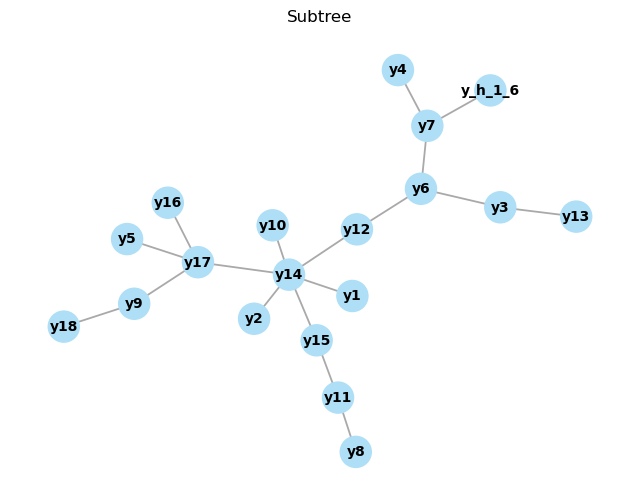

In [156]:
visualize_subtree(task4_skeleton_cleaned)

# Task 5: Obtain the pattern of the latent polytree from task 4

## expand the correlatin matrix from task 1
- make a copy first
- if the pair occurs in the indepence relation we gain from task 4, put 1 in the entry, 0 otherwise 
- make sure all entries get populated by usinmg symmetry of correlation matrix

In [157]:
# create a copy of the original matrix
expanded_matrix = new_correlation_matrix.copy()

# Extract hidden nodes from task4_independence_relations
hidden_nodes = set()
for iteration_relations in task4_independence_relations.values():
    for relations in iteration_relations.values():
        for relation in relations.values():
            for pair in relation:
                for node in pair:
                    if node in pair:
                        if node.startswith('y_h') and node not in hidden_nodes:
                            hidden_nodes.add(node)
                            
# Expand expanded_matrix based on the hidden nodes
for hidden_node in hidden_nodes:
    expanded_matrix[hidden_node] = 0 #add a new column 
    expanded_matrix.loc[hidden_node] = 0 #add a new row 


# Fill up the entries of the expanded correlation matrix based on task4_independence_relations
for iteration_relations in task4_independence_relations.values():
    for relations in iteration_relations.values():
        for relation in relations.values():
            for pair in relation:
                expanded_matrix.loc[pair[0], pair[1]] = 1
                expanded_matrix.loc[pair[1], pair[0]] = 1

# Ensure the diagonal values are 1
np.fill_diagonal(expanded_matrix.values, 1)

- rename the hidden nodes by keep counting forward for better indexing
- update task4_skeleton_cleaned['nodes'] 
- update task4_skeleton_cleaned['edges'] 

In [158]:
def rename_hidden_nodes(nodes):
    # Find the largest visible node number
    max_visible_node = max(int(node[1:]) for node in nodes if not node.startswith('y_h'))
    
    # Create a mapping for renaming and a set for renamed hidden nodes
    rename_map = {}
    renamed_hidden_nodes = set()
    hidden_index = 1
    for node in nodes:
        if node.startswith('y_h'):
            new_name = f'y{max_visible_node + hidden_index}'
            rename_map[node] = new_name
            renamed_hidden_nodes.add(new_name)
            hidden_index += 1
            
    # Rename nodes
    renamed_nodes = [rename_map.get(node, node) for node in nodes]
    return renamed_nodes, rename_map, renamed_hidden_nodes

In [159]:
# get input for rename_hidden_nodes function 
nodes = task4_skeleton_cleaned['nodes']

# retrive renamed_nodes/map/edges from the function above
renamed_nodes, rename_map, renamed_hidden_nodes = rename_hidden_nodes(nodes)

# Update edges with the renamed nodes
renamed_edges = [(rename_map.get(edge[0], edge[0]), rename_map.get(edge[1], edge[1])) for edge in task4_skeleton_cleaned['edges']]

In [160]:
# Use the renamed map to update the column name of our expanded_matrix
expanded_matrix = expanded_matrix.rename(columns=rename_map, index=rename_map)

- have renamed_nodes as V
- have renamed_edges as E 
- use expanded_matrix to indicate independence relations

In [161]:
def clean_edges(edges):
    cleaned_edges = set()
    
    for edge in edges:
        # Sort the edge tuple to maintain consistency
        cleaned_edge = tuple(sorted(edge))
        cleaned_edges.add(cleaned_edge)
    
    return list(cleaned_edges)

In [162]:
renamed_edges_clean = clean_edges(renamed_edges)

In [163]:
def orient_edges_debug(nodes, edges, correlation_matrix):
    is_additional_edges_are_oriented = True
    E_hat = set()
    
    while is_additional_edges_are_oriented:
        is_additional_edges_are_oriented = False
        action_happened = False
        
        for edge1 in edges:
            for edge2 in edges:
                if edge1 != edge2:
                    common_node = set(edge1).intersection(set(edge2))
                    if len(common_node) == 1:
                        common_node = common_node.pop()
                        node1, node2 = set(edge1).difference({common_node}), set(edge2).difference({common_node})
                        node1, node2 = node1.pop(), node2.pop()

                        try:
                            if correlation_matrix.loc[node1, node2] == 0:
                                if (node1, common_node) not in E_hat and (common_node, node1) not in E_hat:
                                    E_hat.add((node1, common_node))
                                    action_happened = True
                                if (node2, common_node) not in E_hat and (common_node, node2) not in E_hat:
                                    E_hat.add((node2, common_node))
                                    action_happened = True
                            elif (node1, common_node) in E_hat or (common_node, node1) in E_hat:
                                if (common_node, node2) not in E_hat and (node2, common_node) not in E_hat:
                                    E_hat.add((common_node, node2))
                                    action_happened = True
                        except KeyError as e:
                            print(f"KeyError occurred: {e}")
                            # Handle the error or continue
        
        if action_happened:
            is_additional_edges_are_oriented = True
    
    return E_hat


In [164]:
from itertools import combinations


In [165]:
def orient_edges(edges, correlation_matrix):
    
    is_additional_edges_are_oriented = True
    E_hat = set()
    
    while is_additional_edges_are_oriented:
        is_additional_edges_are_oriented = False
        action_happened = False

    for edge1, edge2 in combinations(edges, 2):
        common_node = set(edge1).intersection(set(edge2))

        if len(common_node) == 1:
            common_node = common_node.pop()
            node1, node2 = set(edge1).difference({common_node}), set(edge2).difference({common_node})
            node1, node2 = node1.pop(), node2.pop()
            
            if correlation_matrix.loc[node1, node2] == 0 or correlation_matrix.loc[node2, node1] == 0:
                if (node1, common_node) not in E_hat:
                    E_hat.add((node1, common_node))
                    action_happened = True
                if (node2, common_node) not in E_hat:
                    E_hat.add((node2, common_node))
                    action_happened = True

            elif (node1, common_node) in E_hat or (common_node, node2) in edges:
                if (common_node, node2) not in E_hat:
                    E_hat.add((common_node, node2))
                    action_happened = True
        
        if action_happened:
            is_additional_edges_are_oriented = True
    
    return E_hat

In [166]:
E_hat = orient_edges(renamed_edges_clean, expanded_matrix)

In [167]:
def check_bidirectional_edges(E_hat):
    bidirectional_edges = set()
    for edge in E_hat:
        if (edge[1], edge[0]) in E_hat:
            bidirectional_edges.add(edge)
            bidirectional_edges.add((edge[1], edge[0]))
    if bidirectional_edges:
        return bidirectional_edges
    else:
        return False

In [168]:
check_bidirectional_edges_result = check_bidirectional_edges(E_hat)
check_bidirectional_edges_result

{('y14', 'y17'),
 ('y17', 'y14'),
 ('y17', 'y5'),
 ('y17', 'y9'),
 ('y5', 'y17'),
 ('y6', 'y7'),
 ('y7', 'y6'),
 ('y9', 'y17')}

In [169]:
def type_2_detection(E_hat, nodes_list, check_bidirectional_edges_result):
    
    nodes = set(nodes_list)  # Convert the list to a set
    max_node = max(nodes, key=lambda x: int(x[1:]))
    max_index = int(max_node[1:])

    if check_bidirectional_edges_result:
        
        for edge in check_bidirectional_edges_result:
            E_hat.remove(edge)

        unique_bidirectional_edges = set()

        for edge in check_bidirectional_edges_result:
            if (edge[1], edge[0]) not in unique_bidirectional_edges:
                unique_bidirectional_edges.add(edge)

        for edge in unique_bidirectional_edges:
            max_index += 1
            new_node = 'y' + str(max_index)
            nodes.add(new_node)
            E_hat.add((new_node, edge[0]))
            E_hat.add((new_node, edge[1]))
            renamed_hidden_nodes.add(new_node)
    
    else:
        return list(nodes), E_hat

    return list(nodes), E_hat  # Convert the set back to a list if needed


In [170]:
nodes_final, E_hat_final = type_2_detection(E_hat, renamed_nodes, check_bidirectional_edges_result)

In [171]:
def plot_directed_graph(nodes, directed_edges, renamed_hidden_nodes):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for node in nodes:
        G.add_node(node)
    
    # Add directed edges
    for edge in directed_edges:
        G.add_edge(*edge)
    
    # Create a list of node colors based on whether they are in renamed_hidden_nodes
    node_colors = ['lightpink' if node in renamed_hidden_nodes else 'skyblue' for node in G.nodes()]

    # Draw the graph
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=700, node_color=node_colors, font_size=10, font_color='black', font_weight='bold', arrowsize=20, connectionstyle='arc3,rad=0.1')
    plt.show()

    return G


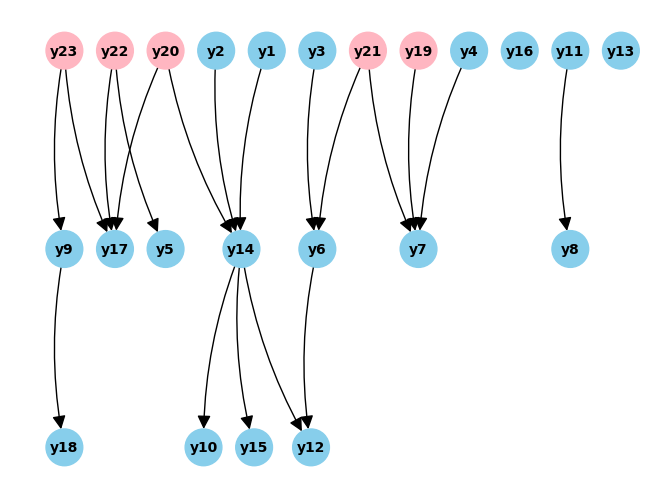

In [172]:
G_1 = plot_directed_graph(nodes_final, E_hat_final, renamed_hidden_nodes)

In [173]:
edge_data = [
    ["1", "20"],
    ["2", "20"],
    ["3", "6"],
    ["19", "6"],
    ["19", "7"],
    ["4", "7"],
    ["5", "22"],
    ["20", "22"],
    ["20", "10"],
    ["20", "23"],
    ["6", "23"],
    ["8", "11"],
    ["21", "11"],
    ["21", "24"],
    ["22", "24"],
    ["22", "25"],
    ["9", "25"],
    ["9", "18"],
    ["23", "12"],
    ["23", "13"],
    ["24", "14"],
    ["24", "15"],
    ["25", "16"],
    ["25", "17"]
]

In [174]:
df_edge = pd.DataFrame(edge_data)

In [175]:
df_edge.columns = ['source', 'target']

In [176]:
G_original = nx.from_pandas_edgelist(df_edge, 'source', 'target', create_using=nx.DiGraph())

In [177]:
number_hidden_recovered = len(renamed_hidden_nodes)
number_nodes_total = df_edge.shape[0]
number_visible_nodes = len(df_data.columns)
true_number_hidden = number_nodes_total - number_visible_nodes
true_number_hidden

6

In [178]:
recover_ratio_hidden = number_hidden_recovered/true_number_hidden

In [179]:
def calculate_shd(G_estimated, G_true):
    """
    Calculate Structural Hamming Distance (SHD) between two graphs.
    SHD is the number of edge disagreements between the two graphs.
    """
    # Find the set of edges in each graph
    edges_estimated = set(G_estimated.edges())
    edges_true = set(G_true.edges())
    
    # Calculate SHD
    shd = len(edges_estimated.symmetric_difference(edges_true))
    return shd

# Example usage
shd_value = calculate_shd(G_original, G_1)
print(f"Structural Hamming Distance (SHD): {shd_value}")


Structural Hamming Distance (SHD): 43


In [180]:
import json

In [181]:
# Assuming shd_value and recover_ratio_hidden are defined earlier in your notebook
algorithm_results = {
    "shd": shd_value,  # These should be actual numeric values, not variable names as strings
    "percentage_hidden_nodes_recovered": recover_ratio_hidden
}

In [182]:
# Correctly outputting JSON string
print("algorithm_result", json.dumps(algorithm_results))

algorithm_result {"shd": 43, "percentage_hidden_nodes_recovered": 0.8333333333333334}
